# COMP 4531 Final Project - Winter 2024

Team: Corey Munk and Kurt Meyer

Topic: Image Classification with the CIFAR-100 data set


The problem is well understood. In your final project, please utilize some pre-built models. While they are generally large and accurate, they should be used to establish the upper bound of performance. Then, demonstrate the detailed steps you took to develop your own model. Of course, using a random classifier to set a baseline is not meaningful.




# Load Packages

In [294]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings('default')

import csv
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load Data

In [321]:
# Load CIFAR-100 data  https://www.cs.toronto.edu/%7Ekriz/cifar.html
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine') #Each image has a "fine" label (class) and a "coarse" label (superclass).

# normalize pixel values
x_train, x_test = x_train/255, x_test/255

y_train_raw = y_train.copy()

#one hot encode labels
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 100)
(10000, 32, 32, 3)
(10000, 100)


## EDA and Data Handling

In [ ]:
# Show sample count by label to visualize the balance of the data
class_labels = y_train_raw.flatten()

plt.figure(figsize=(10,5))
plt.hist(class_labels, bins=np.arange(0,101), alpha=.8, color='green', edgecolor='black')
plt.title(f'Sample Distribution in Classes for CIFAR-100 (n = {len(class_labels)})')
plt.xlabel('Class')
plt.ylabel('Sample Count')
plt.xticks(np.arange(0,101, step=5))
plt.show()


# Display an image from each class in the dataset
distinct_labels = np.unique(y_train_raw)
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

for i, label in enumerate(distinct_labels):
    # Get image and label
    idx = np.where(y_train_raw == label)[0]
    random_index = np.random.choice(idx)
    image, label = x_train[random_index], y_train_raw[random_index][0]
    
    # Define grid cell to place image
    row = i // 10
    col = i % 10
    
    # Display image in defined grid cell
    current_image = (image.reshape((32, 32, 3)) * 255).clip(0, 255).astype(int)
    axes[row, col].imshow(current_image, interpolation='nearest')
    axes[row, col].set_title(f"Label: {label}", fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [267]:
def model_performance(history, model, x_test, y_test):
        # Plots
        plt.figure(figsize=(20, 4))

        # plot accuracy
        plt.subplot(1, 3, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend()

        # plot loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # plot learning rate changes
        plt.subplot(1, 3, 3)
        plt.plot(history.history['lr'], label='Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Changes')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Training Data
        final_train_accuracy = history.history['accuracy'][-1]
        final_train_loss = history.history['loss'][-1]
        print('Training Performance:')
        print(f"Accuracy: {round(final_train_accuracy*100, 2)}%")
        print(f"Loss: {round(final_train_loss, 4)}")

        # Validation Data
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_val_loss = history.history['val_loss'][-1]
        print('\nValidation Performance:')
        print(f"Accuracy: {round(final_val_accuracy*100, 2)}%")
        print(f"Loss: {round(final_val_loss, 4)}")

# model_performance(hist, model, x_test, y_test)

In [271]:
def save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, history):
    model_id = model_id

    # Save model architecture to CSV
    with open('model_architecture.csv', 'a', newline='') as csvfile:
        fieldnames_architecture = ['model_id', 'architecture', 'config']
        writer_architecture = csv.DictWriter(csvfile, fieldnames=fieldnames_architecture)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_architecture.writeheader()

        optimizer_config = optimizer.get_config()
        config = f"op: {optimizer_config['name']}, learning_rate: {optimizer_config['learning_rate']}, " \
                 f"l: {loss}, fltr: {filters}, dor: {dropout_rate}, ks: {kernel_size}, " \
                 f"ps: {pool_size}, du: {dense_units}"

        writer_architecture.writerow({
            'model_id': model_id,
            'architecture': model.to_json(),  # Save model architecture as JSON string
            'config': config
        })

    # Save model performance to CSV
    with open('model_performance.csv', 'a', newline='') as csvfile:
        fieldnames_performance = ['model_id', 'epoch', 'accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate']
        writer_performance = csv.DictWriter(csvfile, fieldnames=fieldnames_performance)

        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer_performance.writeheader()

        for epoch in range(1, len(history.history['accuracy']) + 1):
            writer_performance.writerow({
                'model_id': model_id,
                'epoch': epoch,
                'accuracy': history.history['accuracy'][epoch - 1],
                'loss': history.history['loss'][epoch - 1],
                'val_accuracy': history.history['val_accuracy'][epoch - 1],
                'val_loss': history.history['val_loss'][epoch - 1],
                'learning_rate': history.history.get('lr', [None])[epoch - 1]
            })


## Augmentation

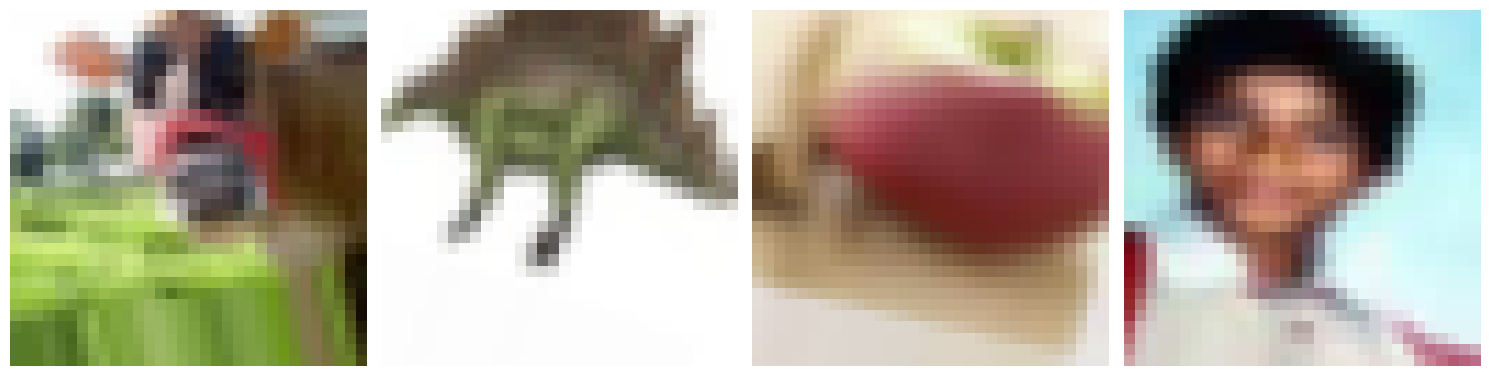

In [286]:
# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    # featurewise_center=True,
    # samplewise_center=True,
    # featurewise_std_normalization=True,
    # samplewise_std_normalization=True,
    # zca_whitening=True,
    # zca_epsilon=1e-06,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    # channel_shift_range=0.3,
    # fill_mode='nearest',
    # cval=0.0,
    # horizontal_flip=True,
    # vertical_flip=True,
    # rescale=None,
    # preprocessing_function=None,
    # data_format=None,
    # validation_split=0.0,
    # interpolation_order=1,
    # dtype=None
)

# Get a batch of augmented images
augmented_images, labels = next(datagen.flow(x_train, y_train, batch_size=4, shuffle=False))

# Plot the augmented images
plt.figure(figsize=(15,10))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## CNN Model

Epoch 1/15
391/391 [==============================] - 38s 93ms/step - loss: 4.3605 - accuracy: 0.0694 - val_loss: 4.8329 - val_accuracy: 0.0235 - lr: 0.0010
Epoch 2/15
391/391 [==============================] - 36s 93ms/step - loss: 3.8830 - accuracy: 0.1101 - val_loss: 3.6450 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 3/15
391/391 [==============================] - 39s 99ms/step - loss: 3.6743 - accuracy: 0.1396 - val_loss: 3.4613 - val_accuracy: 0.1574 - lr: 0.0010
Epoch 4/15
391/391 [==============================] - 39s 100ms/step - loss: 3.5559 - accuracy: 0.1553 - val_loss: 3.6378 - val_accuracy: 0.1505 - lr: 0.0010
Epoch 5/15
391/391 [==============================] - 44s 113ms/step - loss: 3.4689 - accuracy: 0.1691 - val_loss: 3.3716 - val_accuracy: 0.1884 - lr: 0.0010
Epoch 6/15
391/391 [==============================] - 43s 110ms/step - loss: 3.4039 - accuracy: 0.1824 - val_loss: 2.9691 - val_accuracy: 0.2620 - lr: 0.0010
Epoch 7/15
391/391 [==============================] - 4

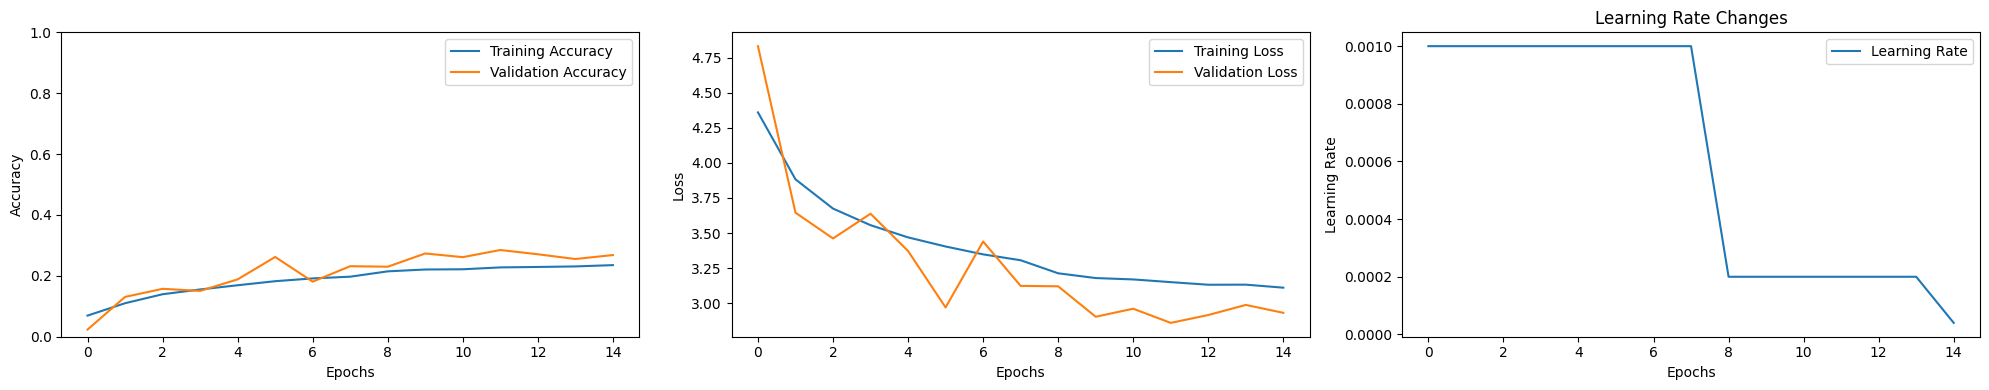

Training Performance:
Accuracy: 23.52%
Loss: 3.1101

Validation Performance:
Accuracy: 26.83%
Loss: 2.9306


In [288]:
# Model params
optimizer=optimizers.Adam(learning_rate=0.001)
loss = 'categorical_crossentropy'
filters = 32
dropout_rate = .3
kernel_size = (3,3)
pool_size = (2,2)
dense_units = 256

# Model execution
epochs = 15
# steps_per_epoch = 100
batch_size = 128

# CNN Architecture
def CNN(op=optimizer, l=loss, fltr=filters, dor=dropout_rate, ks=kernel_size, ps=pool_size, du=dense_units):
    m = models.Sequential()

    m.add(layers.Conv2D(fltr, ks, activation='relu', input_shape=(32, 32, 3)))
    m.add(layers.MaxPool2D(ps))
    m.add(layers.BatchNormalization())
    m.add(layers.Dropout(dor))

    m.add(layers.Conv2D(2*fltr, ks, activation='relu'))
    m.add(layers.MaxPool2D(ps))
    m.add(layers.BatchNormalization())   
    m.add(layers.Dropout(dor))

    m.add(layers.Conv2D(fltr, ks, activation='relu'))
    m.add(layers.MaxPool2D(ps))
    m.add(layers.BatchNormalization())   
    m.add(layers.Dropout(dor))

    m.add(layers.Flatten())
    m.add(layers.Dense(2*du, activation='relu'))
    m.add(layers.BatchNormalization())
    m.add(layers.Dropout(dor))
    m.add(layers.Dense(100, activation='softmax'))
    
    m.compile(
        optimizer = op,
        loss = l,
        metrics = ['accuracy']
    )
    return m

model = CNN()
model_id = f'cnn_{datetime.now().strftime("%Y%m%d_%H%M%S")}'

# Callbacks
tensorboard = TensorBoard(log_dir = 'logs', histogram_freq = 1) # tensorboard --logdir logs
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  patience=2, factor=0.2, mode='min', min_lr= 1e-7, verbose = 1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose = 1, restore_best_weights=True)
checkpoint = ModelCheckpoint(f'../src/models/model_{model_id}.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False)

# Train model and monitor performance using TensorBoard
hist = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    # steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    verbose = 1,
#   batch_size = batch_size,
    validation_data = (x_test, y_test),
    callbacks = [tensorboard, reduce_lr, early_stopping, checkpoint] 
)

model_performance(hist, model, x_test, y_test)
save_model_info(model, model_id, optimizer, loss, filters, dropout_rate, kernel_size, pool_size, dense_units, hist)

## Model Performance

In [331]:
# Load a model to test from the src/models folder
model_file_name = 'cifar100_57accur.h5'
mdl = load_model(f'../src/models/{model_file_name}')

# Make predictions
y_pred = np.argmax(mdl.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 [==============================] - 18s 58ms/step


In [ ]:
# Use the model you just ran
mdl = model

# Make predictions
y_pred = np.argmax(mdl.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

In [341]:
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin',
    'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster',
    'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain',
    'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper',
    'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

mapping_coarse_fine = {
                   'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
                              'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
                           'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
                   'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
              'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
       'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
               'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
                           'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
                  'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
     'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
      'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
    'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
              'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
          'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
                            'people': ['baby', 'boy', 'girl', 'man', 'woman'],
                          'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
                     'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
                             'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
                        'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
                        'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
}

coarse_labels = []
for fine_label in class_names:
    for coarse_label, fine_labels in mapping_coarse_fine.items():
        if fine_label in fine_labels:
            coarse_labels.append(coarse_label)
            break

report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=class_names, output_dict=True)

data = {
    'Coarse Label': coarse_labels,
    'Fine Label': class_names,
    'Error': [round(1 - report[label]['precision'],3)*100 for label in class_names],
    'Precision': [round(report[label]['precision'],3)*100 for label in class_names],
    'Recall': [(report[label]['recall'])*100 for label in class_names],
    'F1-Score': [report[label]['f1-score'] for label in class_names],
    'Population': [np.sum(np.argmax(y_test, axis=1) == idx) for idx in range(len(class_names))]
}

df = pd.DataFrame(data)

df


,Coarse Label,Fine Label,Error,Precision,Recall,F1-Score,Population
0,fruit and vegetables,apple,22.8,77.2,88.0,0.822430,100
1,fish,aquarium_fish,21.1,78.9,71.0,0.747368,100
2,people,baby,44.3,55.7,44.0,0.491620,100
3,large carnivores,bear,51.0,49.0,24.0,0.322148,100
4,aquatic mammals,beaver,61.5,38.5,35.0,0.366492,100
...,...,...,...,...,...,...,...
95,aquatic mammals,whale,49.6,50.4,63.0,0.560000,100
96,trees,willow_tree,30.2,69.8,30.0,0.419580,100
97,large carnivores,wolf,60.3,39.7,71.0,0.508961,100
98,people,woman,60.8,39.2,31.0,0.346369,100


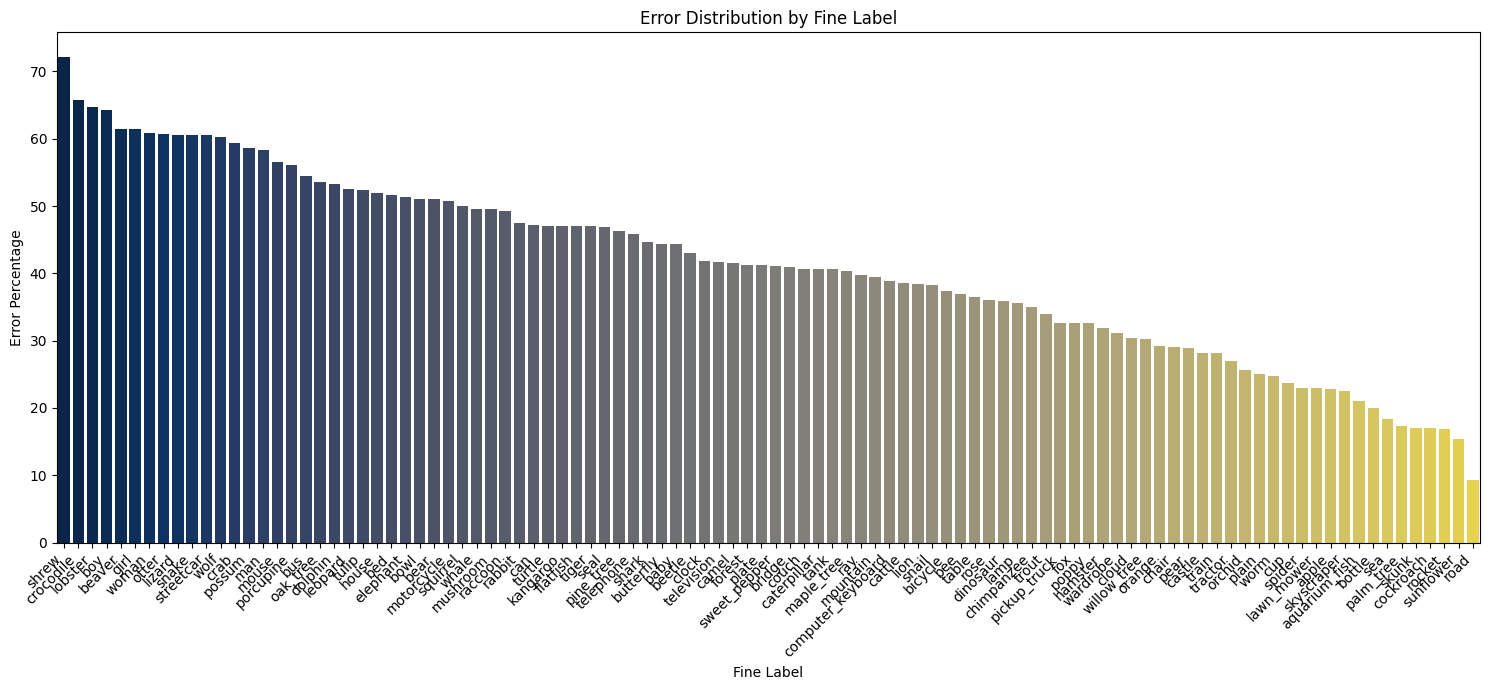

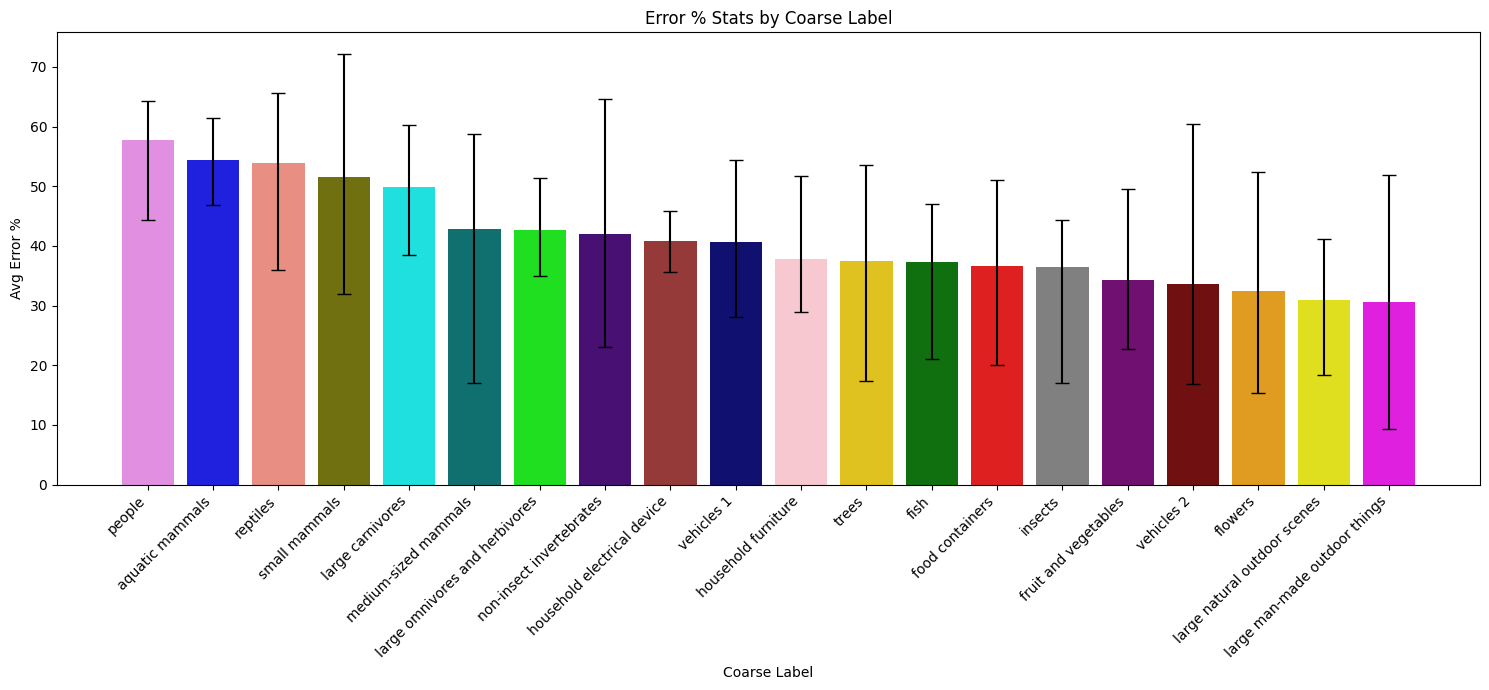

In [395]:
coarse_label_colors = {
    'aquatic mammals': 'blue',
    'fish': 'green',
    'flowers': 'orange',
    'food containers': 'red',
    'fruit and vegetables': 'purple',
    'household electrical device': 'brown',
    'household furniture': 'pink',
    'insects': 'gray',
    'large carnivores': 'cyan',
    'large man-made outdoor things': 'magenta',
    'large natural outdoor scenes': 'yellow',
    'large omnivores and herbivores': 'lime',
    'medium-sized mammals': 'teal',
    'non-insect invertebrates': 'indigo',
    'people': 'violet',
    'reptiles': 'salmon',
    'small mammals': 'olive',
    'trees': 'gold',
    'vehicles 1': 'navy',
    'vehicles 2': 'maroon',
}

# Error Distribution by Fine Label
plt.figure(figsize=(15, 7))
sns.barplot(x='Fine Label', y='Error', data=df.sort_values(by='Error', ascending=False), palette='cividis')
plt.title('Error Distribution by Fine Label')
plt.xlabel('Fine Label')
plt.xticks(rotation=45, ha='right')  
plt.ylabel('Error Percentage')
plt.tight_layout()
plt.show()

# Calc min, mean, max error for each coarse label
error_stats = df.groupby('Coarse Label')['Error'].agg(['mean', 'min', 'max']).reset_index().sort_values(by='mean', ascending=False)
error_stats['color'] = error_stats['Coarse Label'].map(coarse_label_colors)

# Error % Stats by Coarse Label
plt.figure(figsize=(15, 7))
sns.barplot(x='Coarse Label', y='mean', data=error_stats, order=error_stats['Coarse Label'], palette=error_stats['color'])
plt.errorbar(x=error_stats['Coarse Label'], y=error_stats['mean'],
             yerr=[error_stats['mean'] - error_stats['min'], error_stats['max'] - error_stats['mean']],
             fmt='none', color='black', capsize=5, zorder=5)  # zorder to bring error bars to the front
plt.title('Error % Stats by Coarse Label')
plt.xlabel('Coarse Label')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Avg Error %')
plt.tight_layout()
plt.show()

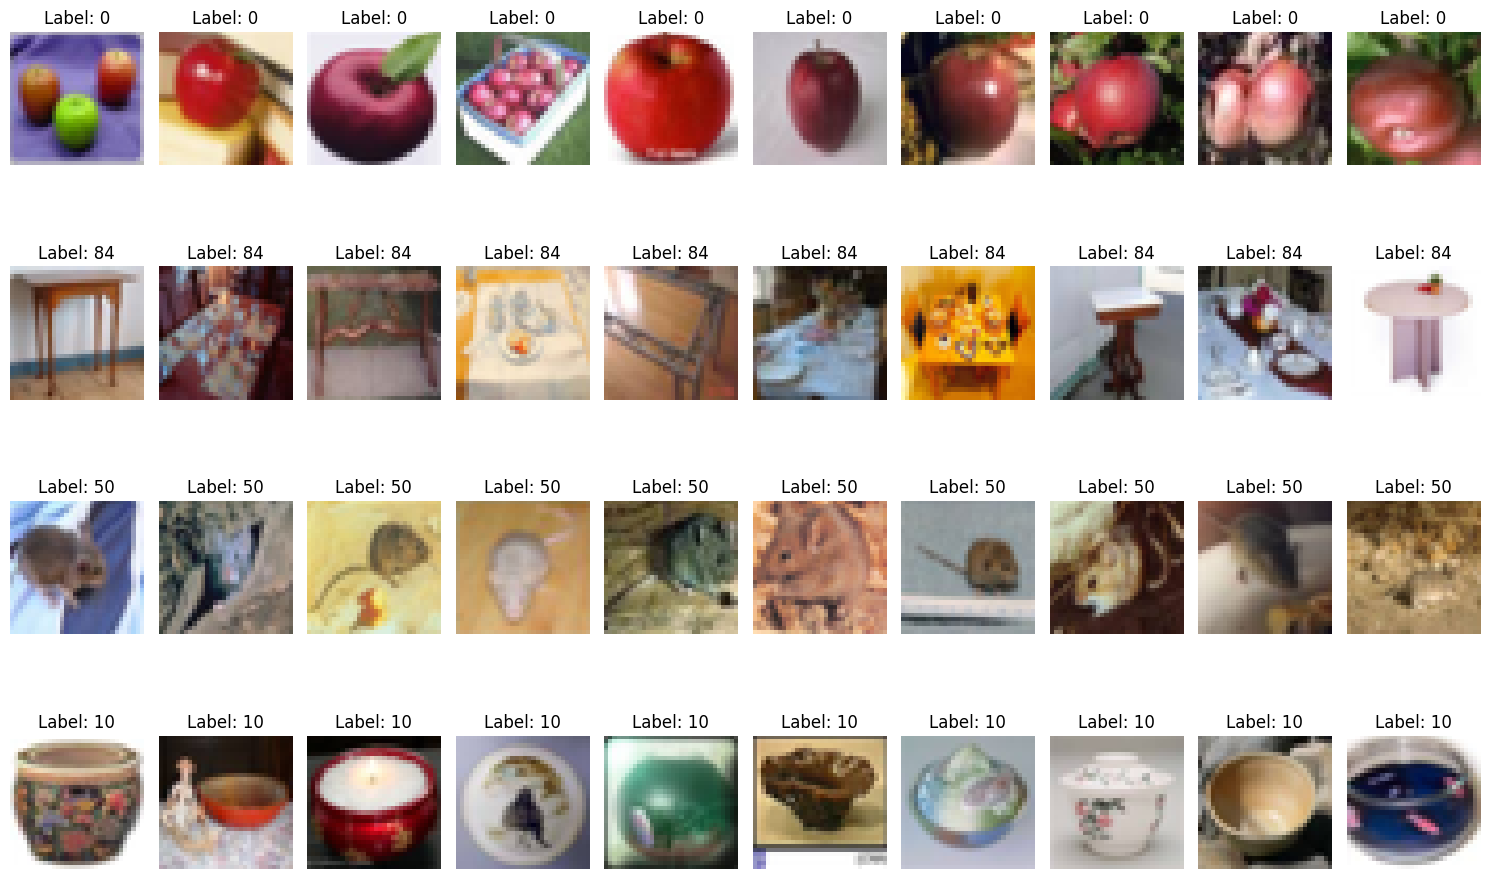

In [309]:
# Filter images for labels 99, 84, 50, and 10
label_indices_to_visualize = [99, 84, 50, 10]
# label_indices_to_visualize = [68, 41, 71, 60]
images_to_visualize = []

for label_index in label_indices_to_visualize:
    label_mask = y_true == label_index
    images_for_label = x_test[label_mask]
    images_to_visualize.append(images_for_label)

# Plot the images
num_labels = len(label_indices_to_visualize)
num_images_per_label = 10

plt.figure(figsize=(15, 10))

for i, label_index in enumerate(label_indices_to_visualize):
    for j in range(num_images_per_label):
        plt.subplot(num_labels, num_images_per_label, i * num_images_per_label + j + 1)
        plt.imshow(images_to_visualize[i][j])
        plt.title(f"Label: {label_index}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Create a DataFrame from the confusion matrix
conf_matrix_df = pd.DataFrame(conf_mat, index=class_names, columns=class_names)

# Display the table
conf_matrix_df